# Heart Failure - Modeling

## Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

from library.sb_utils import save_file

In [2]:
patient_data = pd.read_csv('../data/patient_data_cleaned.csv')
patient_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289.0,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180.0,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283.0,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214.0,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195.0,0,Normal,122,N,0.0,Up,0


In [3]:
X_train = pd.read_csv('../data/patient_data_X_train.csv')
X_train.shape

(687, 15)

In [4]:
X_test = pd.read_csv('../data/patient_data_X_test.csv')
X_test.shape

(230, 15)

In [5]:
y_train = pd.read_csv('../data/patient_data_y_train.csv')
y_train = y_train.values.reshape(-1)
y_train.shape

(687,)

In [6]:
y_test = pd.read_csv('../data/patient_data_y_test.csv')
y_test = y_test.values.reshape(-1)
y_test.shape

(230,)

## Initial Baseline-Model<a id='Initial_Baseline-Model'></a>

In [7]:
#Creation of Baseline-Model based on uniform random predictions (coin flip)
dumb_clf = DummyClassifier(strategy='uniform')
dumb_clf.fit(X_train, y_train)

DummyClassifier(strategy='uniform')

In [8]:
y_tr_pred = dumb_clf.predict(X_train)
y_tr_pred[:5]

array([0, 1, 0, 0, 0])

In [9]:
y_te_pred = dumb_clf.predict(X_test)
y_te_pred[:5]

array([0, 1, 0, 1, 0])

### Scoring Model

In [10]:
def ROC_AUC_Graph(model):
    #Generate a baseline prediction
    bs_probs = [0 for i in range(len(y_test))]
    op_probs = model.predict(X_test)

    #Calculate scores
    bs_auc = roc_auc_score(y_test, bs_probs)
    op_auc = roc_auc_score(y_test, op_probs)


    print('Baseline Algorithm:ROC AUC=%.3f' % (bs_auc))
    print('Baseline Model: ROC AUC=%.3f' % (op_auc))

    #Calculate roc curves
    bs_fpr, bs_tpr, _ = roc_curve(y_test, bs_probs)
    op_fpr, op_tpr, _ = roc_curve(y_test, op_probs)

    #Plot the roc curve for the model
    plt.plot(bs_fpr, bs_tpr, linestyle='--', label='Baseline')
    plt.plot(op_fpr, op_tpr, marker='.', label='Model')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

Baseline Algorithm:ROC AUC=0.500
Baseline Model: ROC AUC=0.477


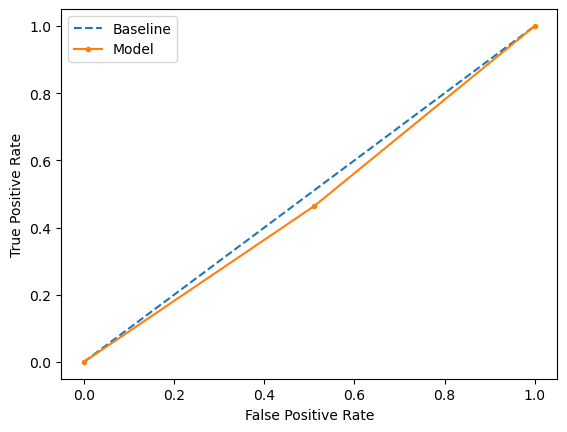

In [11]:
ROC_AUC_Graph(dumb_clf)

In [12]:
print(classification_report(y_test, y_te_pred))

              precision    recall  f1-score   support

           0       0.45      0.59      0.51        90
           1       0.67      0.54      0.60       140

    accuracy                           0.56       230
   macro avg       0.56      0.57      0.56       230
weighted avg       0.59      0.56      0.57       230



<AxesSubplot:>

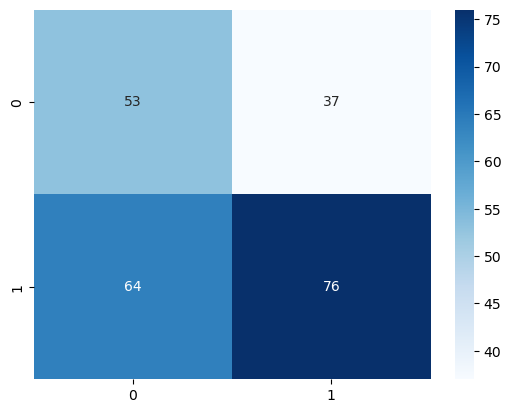

In [13]:
#Confusion Matrix
pl = confusion_matrix(y_test,y_te_pred)
sns.heatmap(pl, annot=True,cmap='Blues', fmt='g')

## Logistic Regression Model<a id='Logistic_Regression_Model'></a>

In [14]:
#Logistic Regression Pipeline
lg_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
    LogisticRegression(random_state=42)
)

In [15]:
lg_default_cv_results = cross_validate(lg_pipe, X_train, y_train, cv=5,scoring='roc_auc')

In [16]:
lg_cv_scores = lg_default_cv_results['test_score']
np.mean(lg_cv_scores), np.std(lg_cv_scores)

(0.9243497778600519, 0.025235692703012267)

### Grid Search

In [17]:
param_grid = [
    {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']}]

lg_grid_cv = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv = 5, n_jobs=-1, scoring='roc_auc')

In [18]:
lg_grid_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}],
             scoring='roc_auc')

In [19]:
lg_grid_cv.best_params_

{'C': 0.615848211066026, 'penalty': 'l2', 'solver': 'liblinear'}

### Scoring Model

In [20]:
lg_best_model = lg_grid_cv.best_estimator_

In [21]:
lg_cv_scores_test = cross_validate(lg_best_model, X_test, y_test, cv=5, scoring='roc_auc')
lg_cv_scores_train = cross_validate(lg_best_model, X_train, y_train, cv=5, scoring='roc_auc')
print(lg_cv_scores_test)
lg_cv_train = np.mean(lg_cv_scores_train['test_score'])
lg_cv_test = np.mean(lg_cv_scores_test['test_score'])
lg_cv_std = np.std(lg_cv_scores_test['test_score'])
lg_cv_fit = np.mean(lg_cv_scores_test['fit_time'])
print ('Mean cross validation train score: ' +str(lg_cv_train))
print ('Mean cross validation test score: ' +str(lg_cv_test))
print ('Standard deviation in cv scores: ' +str(lg_cv_std))
print ('Mean cross validation fit time: ' +str(round(lg_cv_fit,4)))

{'fit_time': array([0.00505376, 0.00229597, 0.00187111, 0.0015521 , 0.00143313]), 'score_time': array([0.00257325, 0.00194383, 0.00149703, 0.00132394, 0.00128293]), 'test_score': array([0.8968254 , 0.93452381, 0.90277778, 0.88888889, 0.96230159])}
Mean cross validation train score: 0.9248189328026657
Mean cross validation test score: 0.9170634920634921
Standard deviation in cv scores: 0.027418309000197958
Mean cross validation fit time: 0.0024


Baseline Algorithm:ROC AUC=0.500
Baseline Model: ROC AUC=0.867


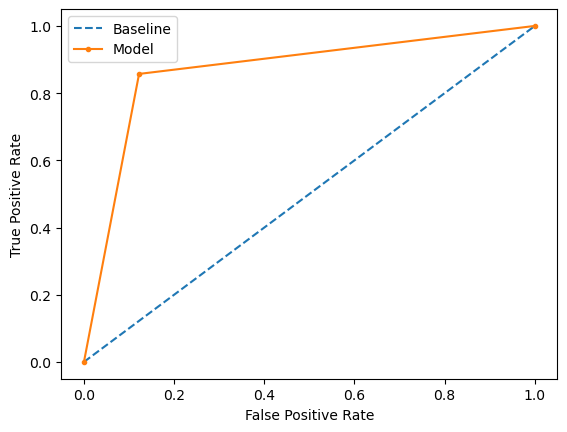

In [22]:
ROC_AUC_Graph(lg_best_model)

In [23]:
y_lg_pred = lg_best_model.predict(X_test)

In [24]:
report = classification_report(y_test, y_lg_pred, output_dict = True)
lg_precision = report['weighted avg']['precision']
lg_recall = report['weighted avg']['recall']
lg_accuracy = report['accuracy']
print(classification_report(y_test, y_lg_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84        90
           1       0.92      0.86      0.89       140

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



<AxesSubplot:>

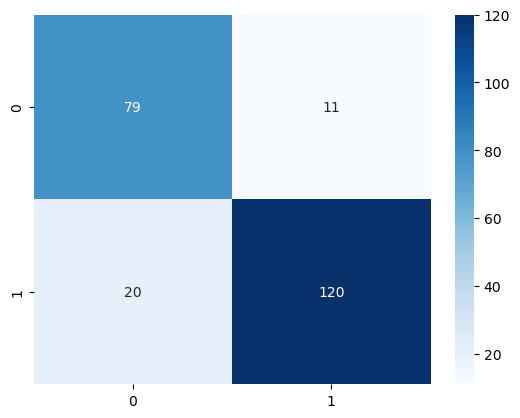

In [25]:
#Confusion Matrix
pl = confusion_matrix(y_test,y_lg_pred)
sns.heatmap(pl, annot=True,cmap='Blues', fmt='g')

## Random Forest Model<a id='Random_Forest_Model'></a>

In [26]:
rf_pipe = make_pipeline(
    RandomForestClassifier(random_state=42)
)

In [27]:
rf_default_cv_results = cross_validate(rf_pipe, X_train, y_train, cv=5, scoring='roc_auc')

In [28]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.95692568, 0.92303632, 0.8989726 , 0.8989726 , 0.8953339 ])

In [29]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.9146482205664569, 0.02333339319733644)

### Random Search

In [31]:
rf_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'randomforestclassifier', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [35]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
params = {
        'randomforestclassifier__n_estimators': n_est,
        'randomforestclassifier__criterion': ['gini', 'entropy'],
        'randomforestclassifier__max_depth': range(10, 110, 10),
        'randomforestclassifier__bootstrap': [True, False],
        'randomforestclassifier__max_features': ['auto', 'sqrt', None]
}

In [36]:
rf_random_cv = RandomizedSearchCV(rf_pipe, params, cv=5, n_jobs=-1, scoring ='roc_auc')

In [37]:
rf_random_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__bootstrap': [True,
                                                                              False],
                                        'randomforestclassifier__criterion': ['gini',
                                                                              'entropy'],
                                        'randomforestclassifier__max_depth': range(10, 110, 10),
                                        'randomforestclassifier__max_features': ['auto',
                                                                                 'sqrt',
                                                                                 None],
                                        'randomforestclassifier__n_estimat

In [38]:
rf_random_cv.best_params_

{'randomforestclassifier__n_estimators': 615,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_depth': 90,
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__bootstrap': True}

### Scoring Model

In [39]:
rf_best_model = rf_random_cv.best_estimator_

In [40]:
rf_cv_scores_test = cross_validate(rf_best_model, X_test, y_test, cv=5, scoring='roc_auc')
rf_cv_scores_train = cross_validate(rf_best_model, X_train, y_train, cv=5, scoring='roc_auc')
print(rf_cv_scores_test)
rf_cv_train = np.mean(rf_cv_scores_train['test_score'])
rf_cv_test = np.mean(rf_cv_scores_test['test_score'])
rf_cv_std = np.std(rf_cv_scores_test['test_score'])
rf_cv_fit = np.mean(rf_cv_scores_test['fit_time'])
print ('Mean cross validation train score: ' +str(rf_cv_train))
print ('Mean cross validation test score: ' +str(rf_cv_test))
print ('Standard deviation in cv scores: ' +str(rf_cv_std))
print ('Mean cross validation fit time: ' +str(round(rf_cv_fit,4)))

{'fit_time': array([0.428509  , 0.40015316, 0.40058708, 0.40159392, 0.39747477]), 'score_time': array([0.02733612, 0.02729392, 0.02742505, 0.02702093, 0.02691817]), 'test_score': array([0.89285714, 0.93452381, 0.93055556, 0.88194444, 0.91765873])}
Mean cross validation train score: 0.9196171556830803
Mean cross validation test score: 0.9115079365079366
Standard deviation in cv scores: 0.020747176344713996
Mean cross validation fit time: 0.4057


Baseline Algorithm:ROC AUC=0.500
Baseline Model: ROC AUC=0.865


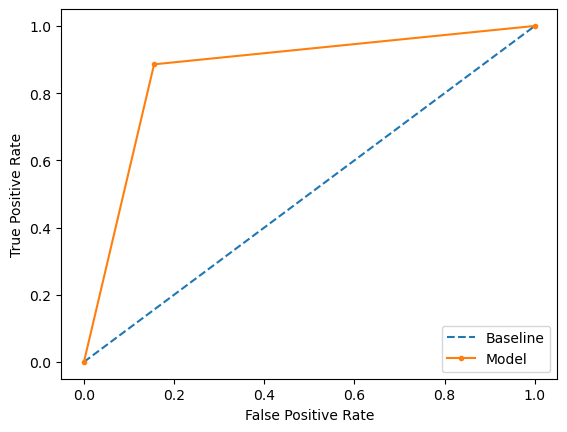

In [41]:
ROC_AUC_Graph(rf_best_model)

In [42]:
y_rf_pred = rf_best_model.predict(X_test)

In [43]:
report = classification_report(y_test, y_rf_pred, output_dict = True)
rf_precision = report['weighted avg']['precision']
rf_recall = report['weighted avg']['recall']
rf_accuracy = report['accuracy']
print(classification_report(y_test, y_rf_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84        90
           1       0.90      0.89      0.89       140

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



<AxesSubplot:>

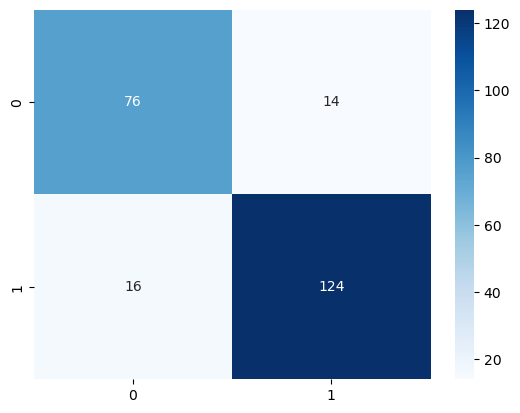

In [44]:
#Confusion Matrix
pl = confusion_matrix(y_test,y_rf_pred)
sns.heatmap(pl, annot=True,cmap='Blues', fmt='g')

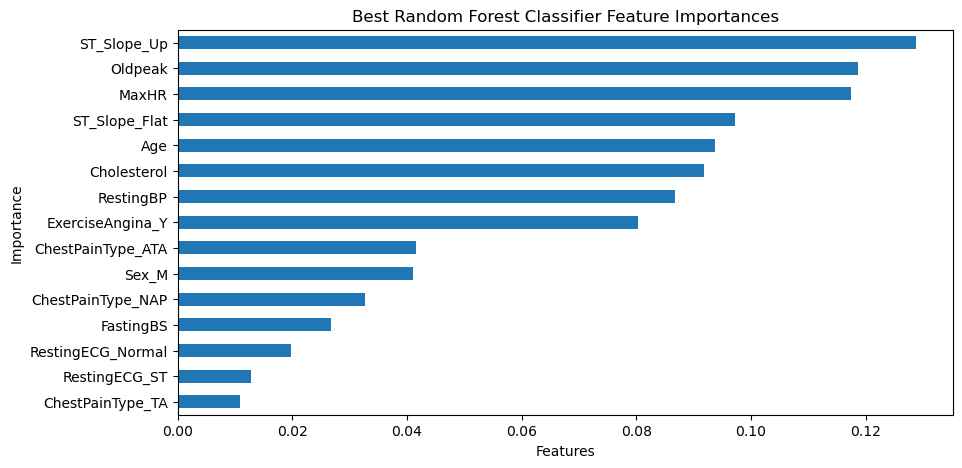

In [45]:
plt.subplots(figsize=(10, 5))
imps = rf_random_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_
rf_feat_imps = pd.Series(data = imps, index=X_train.columns).sort_values(ascending=True)
rf_feat_imps.plot(kind='barh')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Best Random Forest Classifier Feature Importances');

## K-Nearest Neighbor (KNN) Model

In [46]:
#KNN Pipeline
knn_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
    KNeighborsClassifier()
)

In [47]:
knn_default_cv_results = cross_validate(knn_pipe, X_train, y_train, cv=5, scoring='roc_auc')

In [48]:
knn_cv_scores = knn_default_cv_results['test_score']
knn_cv_scores

array([0.92652027, 0.90033784, 0.90196918, 0.85455908, 0.84952911])

In [49]:
np.mean(knn_cv_scores), np.std(knn_cv_scores)

(0.8865830942243613, 0.029730247700203032)

### Grid Search

In [50]:
knn_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'minmaxscaler', 'kneighborsclassifier', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'minmaxscaler__clip', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])

In [51]:
n_est = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)]
params = {
        'kneighborsclassifier__n_neighbors': n_est,
        'kneighborsclassifier__weights': ['uniform','distance'],
        'kneighborsclassifier__metric': ['euclidean','manhattan','chebyshev','minkowski']
        
}

In [52]:
knn_grid_cv = GridSearchCV(knn_pipe, params, cv=5, n_jobs=-1, scoring ='roc_auc')

In [53]:
knn_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__metric': ['euclidean',
                                                          'manhattan',
                                                          'chebyshev',
                                                          'minkowski'],
                         'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9,
                                                               11, 13, 15, 17,
                                                               19, 21, 23, 25,
                                                               27, 29, 31, 33,
                     

In [54]:
knn_grid_cv.best_params_

{'kneighborsclassifier__metric': 'manhattan',
 'kneighborsclassifier__n_neighbors': 65,
 'kneighborsclassifier__weights': 'distance'}

### Scoring Model

In [55]:
knn_best_model = knn_grid_cv.best_estimator_

In [56]:
knn_cv_scores_test = cross_validate(knn_best_model, X_test, y_test, cv=5, scoring='roc_auc')
knn_cv_scores_train = cross_validate(knn_best_model, X_train, y_train, cv=5, scoring='roc_auc')
print(knn_cv_scores_test)
knn_cv_train = np.mean(knn_cv_scores_train['test_score'])
knn_cv_test = np.mean(knn_cv_scores_test['test_score'])
knn_cv_std = np.std(knn_cv_scores_test['test_score'])
knn_cv_fit = np.mean(knn_cv_scores_test['fit_time'])
print ('Mean cross validation train score: ' +str(knn_cv_train))
print ('Mean cross validation test score: ' +str(knn_cv_test))
print ('Standard deviation in cv scores: ' +str(knn_cv_std))
print ('Mean cross validation fit time: ' +str(round(knn_cv_fit,4)))

{'fit_time': array([0.00462413, 0.00289512, 0.00318098, 0.00272799, 0.00352812]), 'score_time': array([0.00362706, 0.0031991 , 0.00277805, 0.00300598, 0.0026629 ]), 'test_score': array([0.92261905, 0.93452381, 0.90277778, 0.8968254 , 0.93253968])}
Mean cross validation train score: 0.9242427573121066
Mean cross validation test score: 0.9178571428571429
Standard deviation in cv scores: 0.015399688818993852
Mean cross validation fit time: 0.0034


Baseline Algorithm:ROC AUC=0.500
Baseline Model: ROC AUC=0.851


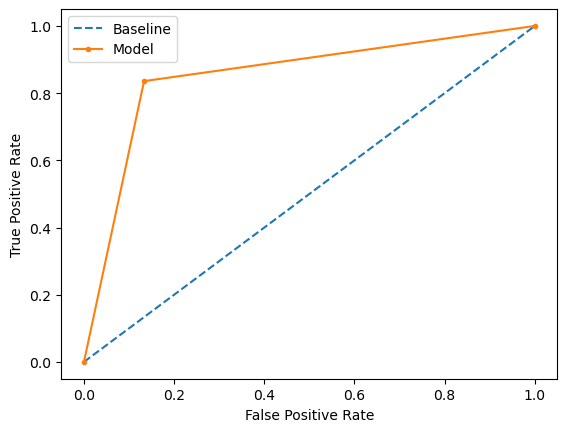

In [57]:
ROC_AUC_Graph(knn_best_model)

In [58]:
y_knn_pred = knn_best_model.predict(X_test)
report = classification_report(y_test, y_knn_pred, output_dict = True)
knn_precision = report['weighted avg']['precision']
knn_recall = report['weighted avg']['recall']
knn_accuracy = report['accuracy']
print(classification_report(y_test, y_knn_pred))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82        90
           1       0.91      0.84      0.87       140

    accuracy                           0.85       230
   macro avg       0.84      0.85      0.84       230
weighted avg       0.85      0.85      0.85       230



<AxesSubplot:>

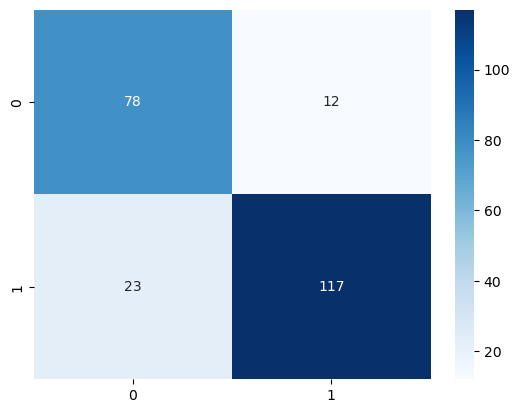

In [59]:
#Confusion Matrix
pl = confusion_matrix(y_test,y_knn_pred)
sns.heatmap(pl, annot=True,cmap='Blues', fmt='g')

## Gradient Boosting

In [60]:
#Gradient Boosting Pipeline
gb_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
    GradientBoostingClassifier(random_state=42)
)

In [61]:
gb_default_cv_results = cross_validate(gb_pipe, X_train, y_train, cv=5, scoring='roc_auc')

In [62]:
gb_cv_scores = gb_default_cv_results['test_score']
gb_cv_scores

array([0.95481419, 0.92335304, 0.90389555, 0.90089897, 0.88570205])

In [63]:
np.mean(gb_cv_scores), np.std(gb_cv_scores)

(0.9137327610144391, 0.023779953306054372)

### Random Search

In [64]:
gb_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'minmaxscaler', 'gradientboostingclassifier', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'minmaxscaler__clip', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'gradientboostingclassifier__ccp_alpha', 'gradientboostingclassifier__criterion', 'gradientboostingclassifier__init', 'gradientboostingclassifier__learning_rate', 'gradientboostingclassifier__loss', 'gradientboostingclassifier__max_depth', 'gradientboostingclassifier__max_features', 'gradientboostingclassifier__max_leaf_nodes', 'gradientboostingclassifier__min_impurity_decrease', 'gradientboostingclassifier__min_samples_leaf', 'gradientboostingclassifier__min_samples_split', 'gradientboostingclassifier__min_weight_fraction_leaf', 'gradientboostingclassifier__n_estimators', 'gradientboostingclassifier__n_iter_no_change', 'gradientboostingclassi

In [65]:
n_est = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)]
sam_split = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 18)]
max_depth = [int(x) for x in np.linspace(start = 4, stop = 16, num = 6)]
params = {
        'gradientboostingclassifier__n_estimators': n_est,
        'gradientboostingclassifier__criterion': ['friedman_mse', 'squared_error'],
        'gradientboostingclassifier__max_depth': max_depth,
        'gradientboostingclassifier__learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1],
        'gradientboostingclassifier__min_samples_split': sam_split,
        'gradientboostingclassifier__warm_start':[True, False]
}

In [66]:
gb_random_cv = RandomizedSearchCV(gb_pipe, params, cv=5, n_jobs=-1, scoring ='roc_auc')

In [67]:
gb_random_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('minmaxscaler', MinMaxScaler()),
                                             ('gradientboostingclassifier',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'gradientboostingclassifier__criterion': ['friedman_mse',
                                                                                  'squared_error'],
                                        'gradientboostingclassifier__learnin...
                                                                                  8,
                                                                                  11,
                                                                                  13,
                 

In [68]:
gb_random_cv.best_params_

{'gradientboostingclassifier__warm_start': False,
 'gradientboostingclassifier__n_estimators': 37,
 'gradientboostingclassifier__min_samples_split': 517,
 'gradientboostingclassifier__max_depth': 16,
 'gradientboostingclassifier__learning_rate': 0.25,
 'gradientboostingclassifier__criterion': 'squared_error'}

### Scoring Model

In [69]:
gb_best_model = gb_random_cv.best_estimator_

In [82]:
gb_cv_scores_test = cross_validate(gb_best_model, X_test, y_test, cv=5, scoring='roc_auc')
gb_cv_scores_train = cross_validate(gb_best_model, X_train, y_train, cv=5, scoring='roc_auc')
print(gb_cv_scores_test)
gb_cv_train = np.mean(gb_cv_scores_train['test_score'])
gb_cv_test = np.mean(gb_cv_scores_test['test_score'])
gb_cv_std = np.std(gb_cv_scores_test['test_score'])
gb_cv_fit = np.mean(gb_cv_scores_test['fit_time'])
print ('Mean cross validation train score: ' +str(gb_cv_train))
print ('Mean cross validation test score: ' +str(gb_cv_test))
print ('Standard deviation in cv scores: ' +str(gb_cv_std))
print ('Mean cross validation fit time: ' +str(round(gb_cv_fit,4)))

{'fit_time': array([0.01419783, 0.00901771, 0.00990415, 0.01055098, 0.00840712]), 'score_time': array([0.00197005, 0.00174308, 0.00242686, 0.00173497, 0.00143886]), 'test_score': array([0.5, 0.5, 0.5, 0.5, 0.5])}
Mean cross validation train score: 0.9234227485190669
Mean cross validation test score: 0.5
Standard deviation in cv scores: 0.0
Mean cross validation fit time: 0.0104


Baseline Algorithm:ROC AUC=0.500
Baseline Model: ROC AUC=0.880


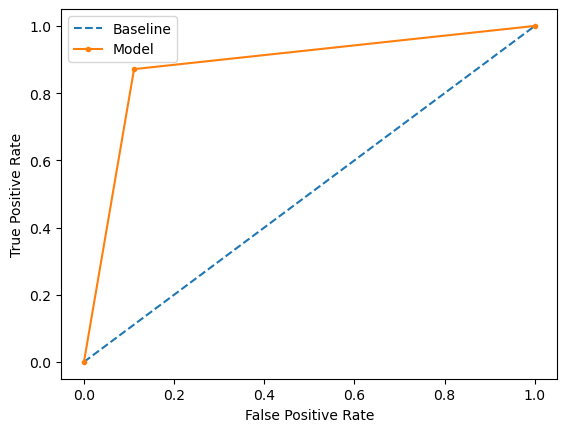

In [71]:
ROC_AUC_Graph(gb_best_model)

In [72]:
y_gb_pred = gb_best_model.predict(X_test)
report = classification_report(y_test, y_gb_pred, output_dict = True)
gb_precision = report['weighted avg']['precision']
gb_recall = report['weighted avg']['recall']
gb_accuracy = report['accuracy']
print(classification_report(y_test, y_gb_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        90
           1       0.92      0.87      0.90       140

    accuracy                           0.88       230
   macro avg       0.87      0.88      0.87       230
weighted avg       0.88      0.88      0.88       230



<AxesSubplot:>

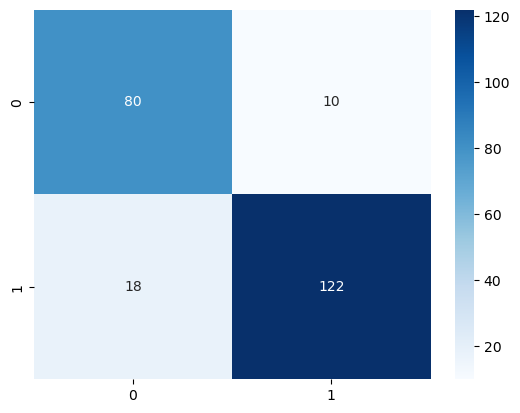

In [73]:
#Confusion Matrix
pl = confusion_matrix(y_test,y_gb_pred)
sns.heatmap(pl, annot=True,cmap='Blues', fmt='g')

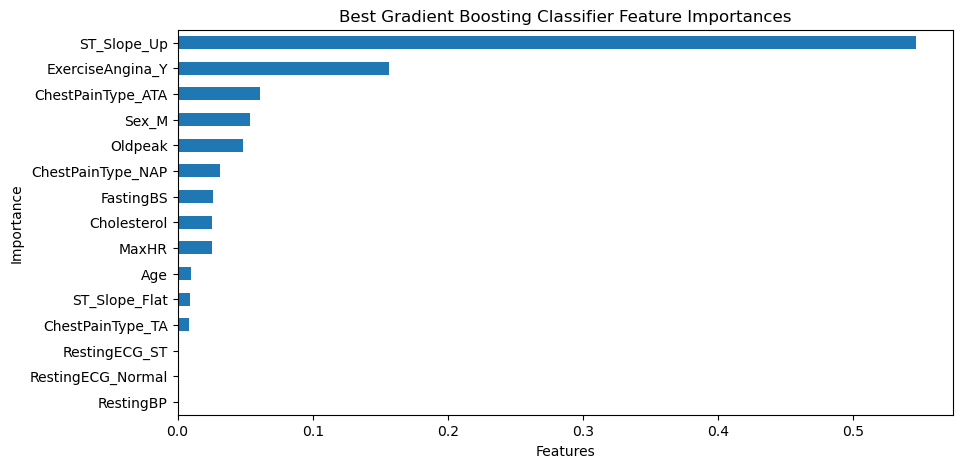

In [74]:
plt.subplots(figsize=(10, 5))
imps = gb_random_cv.best_estimator_.named_steps.gradientboostingclassifier.feature_importances_
rf_feat_imps = pd.Series(data = imps, index=X_train.columns).sort_values(ascending=True)
rf_feat_imps.plot(kind='barh')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Best Gradient Boosting Classifier Feature Importances');

## Comparison of the models

In [75]:
myLabels = ['Logistic Regression','Random Forest','KNN','Gradient Boost']
score_test= [lg_cv_test, rf_cv_test, knn_cv_test, gb_cv_test]
score_train= [lg_cv_train, rf_cv_train, knn_cv_train, gb_cv_train]
fit_time = [round(lg_cv_fit,4),round(rf_cv_fit,4),round(knn_cv_fit,4),round(gb_cv_fit,4)]
precision = [lg_precision, rf_precision, knn_precision, gb_precision]
recall = [lg_recall, rf_recall, knn_recall, gb_recall]
accuracy = [lg_accuracy, rf_accuracy, knn_accuracy, gb_accuracy]

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test, precision, recall, accuracy, fit_time)), 
               columns =['Algorithm', 'ROC-AUC Train Score', 'ROC-AUC Test Score','Precision', 'Recall', 'Accuracy','Fit Time']) 

score_tab

,Algorithm,ROC-AUC Train Score,ROC-AUC Test Score,Precision,Recall,Accuracy,Fit Time
0,Logistic Regression,0.924819,0.917063,0.869837,0.865217,0.865217,0.0024
1,Random Forest,0.919617,0.911508,0.870195,0.869565,0.869565,0.4057
2,KNN,0.924243,0.917857,0.854268,0.847826,0.847826,0.0034
3,Gradient Boost,0.923423,0.500000,0.882014,0.878261,0.878261,0.0103


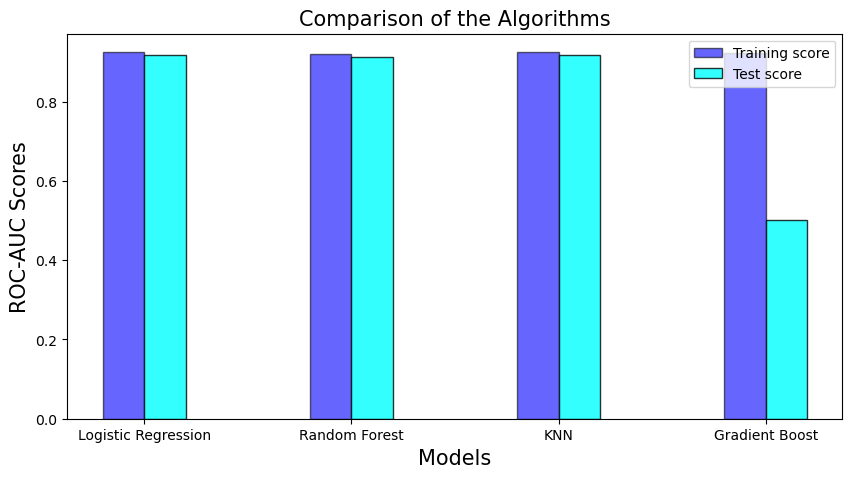

In [84]:
#plotting and comparing ROC-AUC train/test scores:

index=[1,2,3,4]
index_acc=[1.2,2.2,3.2,4.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('ROC-AUC Scores',fontsize=15)
plt.title('Comparison of the Algorithms',fontsize=15)
_=plt.bar(index,score_train,color='b',alpha=0.6,label='Training score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1.1, 2.1,3.1,4.1], myLabels)
plt.legend()
plt.show()

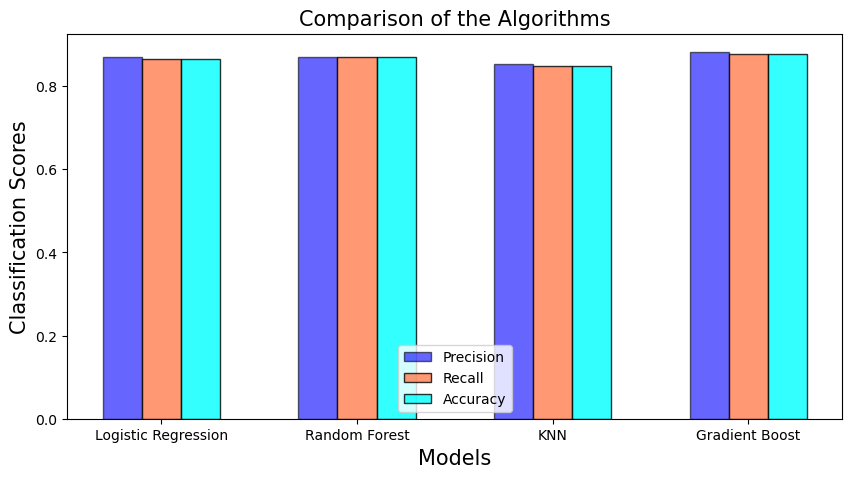

In [83]:
#plotting and comparing ROC-AUC train/test scores:

index=[1,2,3,4]
index_abb=[1.2,2.2,3.2,4.2]
index_acc=[1.4,2.4,3.4,4.4]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Classification Scores',fontsize=15)
plt.title('Comparison of the Algorithms',fontsize=15)
_=plt.bar(index,precision,color='b',alpha=0.6,label='Precision',edgecolor='k',width=0.2)
_=plt.bar(index_abb,recall,color='coral',alpha=0.8,label='Recall',edgecolor='k',width=0.2)
_=plt.bar(index_acc,accuracy,color='cyan',alpha=0.8,label='Accuracy',edgecolor='k',width=0.2)
plt.xticks([1.2, 2.2, 3.2, 4.2], myLabels)
plt.legend()
plt.show()

##  Conclusion

To begin the process of modeling the provided data, it was crucial to swiftly establish a baseline model that could serve as a reference point for evaluating other models. For this purpose, I implemented a dummy classifier that employed a uniform prediction method, akin to flipping a coin, to make predictions on the test data. By evaluating its performance using ROC AUC, a classification report, and a confusion matrix, I obtained the necessary baseline data to commence the implementation of four selected models that held the most promise for achieving the desired outcome. The chosen models were: Logistic Regression, KNN, Random Forest, and Gradient Boosting.

For each of these models, I followed a similar procedure. Firstly, I constructed individual pipelines utilizing the aforementioned models, and then employed either grid search or random search cross-validation, depending on the model's characteristics and fitting time. Finally, I evaluated each model using the scoring methods mentioned above. After comparing the obtained scores, it became evident that the Gradient Boost model emerged as the optimal choice, exhibiting the highest ROC-AUC, Precision, Recall, and Accuracy scores. Considering the nature of this medical situation, false positives are preferable to false negatives, as such recall holds particular significance in this determination. Fortunately, the gradient boost model outperformed all other models in scoring metrics except for fit time, eliminating the need to prioritize specific scoring values.
